# Loading Libraries for the Code

In [683]:
# Loading Libaries
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import os
import torch.nn.functional as F

# Define the folder name
folder_name = "Data"

# 1. Load Data

In [684]:
# Loading the Boston Dataset
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
boston_data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2,
:2]])
boston_target = raw_df.values[1::2, 2]

In [685]:
print(boston_data.shape)

(506, 13)


In [686]:
print(boston_target.shape)

(506,)


In [687]:
boston_data.shape

(506, 13)

In [688]:
# Assuming the targe  t values are in the last column (13th column)
features = boston_data[:, :-1]   # All columns except the last one
targets = boston_data[:, -1]     # Last column

In [689]:
best_test_loss = float('inf')  # Initialize with a large value
loss_name = ""

## Split the Input Dataset into Training and Testing Dataset

In [690]:
# Split the dataset into training and testing sets
# 80% of the data will be used for training and 20% for testing
# The random_state parameter ensures reproducibility of the split

X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)

# Now X_train and y_train are the training features and target values, respectively
# X_test and y_test are the testing features and target values, respectively

# 2. Model

In [691]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [692]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [693]:
# Convert to PyTorch tensors Standardized
X_train_tensor_scaled = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor_scaled = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor_scaled = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor_scaled = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [694]:
class SwishFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return input * torch.sigmoid(input)

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        sigmoid_input = torch.sigmoid(input)
        return grad_output * (sigmoid_input * (1 + input * (1 - sigmoid_input)))

class Swish(nn.Module):
    def forward(self, input):
        return SwishFunction.apply(input)


In [695]:
class GeluFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return 0.5 * input * (1 + torch.tanh(0.79788456 * (input + 0.044715 * torch.pow(input, 3))))

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        tanh_output = torch.tanh(0.79788456 * (input + 0.044715 * torch.pow(input, 3)))
        sigmoid_derivative = 0.5 * (1 + torch.tanh(input + 0.79788456 * (input + 0.044715 * torch.pow(input, 3)))) * (1 - tanh_output ** 2)
        return grad_output * sigmoid_derivative * (0.79788456 * (1 + 0.044715 * torch.pow(input, 2)) + 0.79788456 * input * 3 * 0.044715 * torch.pow(input, 2))


class Gelu(nn.Module):
    def forward(self, input):
        return GeluFunction.apply(input)



In [696]:
# Define the neural network class with ReLU Activation Function
class RegressionNetReLU(nn.Module):
    def __init__(self):
        super(RegressionNetReLU, self).__init__()
        self.layer1 = nn.Linear(X_train.shape[1], X_train.shape[0])
        self.layer2 = nn.Linear(X_train.shape[0], 1)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = self.layer2(x)
        return x

In [697]:
# Define the neural network class with ReLU Activation Function
class RegressionNetSigmoid(nn.Module):
    def __init__(self):
        super(RegressionNetSigmoid, self).__init__()
        self.layer1 = nn.Linear(X_train.shape[1], X_train.shape[0])
        self.layer2 = nn.Linear(X_train.shape[0], 1)

    def forward(self, x):
        x = torch.sigmoid(self.layer1(x))
        x = self.layer2(x)
        return x

In [698]:
# Define the neural network class with ReLU Activation Function
class RegressionNetSwish(nn.Module):
    def __init__(self):
        super(RegressionNetSwish, self).__init__()
        self.layer1 = nn.Linear(X_train.shape[1], X_train.shape[0])
        self.layer2 = nn.Linear(X_train.shape[0], 1)
        self.swish = Swish()  # Apply Swish activation

    def forward(self, x):
        x = self.swish(self.layer1(x))
        x = self.layer2(x)
        return x

In [699]:
# Define the neural network class with ReLU Activation Function
class RegressionNetGelu(nn.Module):
    def __init__(self):
        super(RegressionNetGelu, self).__init__()
        self.layer1 = nn.Linear(X_train.shape[1], X_train.shape[0])
        self.layer2 = nn.Linear(X_train.shape[0], 1)
        self.gelu = Gelu()

    def forward(self, x):
        x = self.gelu(self.layer1(x))
        x = self.layer2(x)
        return x

In [700]:
loss_relu = np.array([])
loss_sig = np.array([])
loss_swish = np.array([])
loss_gelu = np.array([])

In [701]:
model = RegressionNetReLU()
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training loop
epochs = 1000
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor_scaled)
    loss = criterion(outputs, y_train_tensor_scaled)
    loss.backward()
    optimizer.step()
    loss_relu = np.append(loss_relu, loss.item())
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor_scaled)
    test_loss = criterion(y_pred, y_test_tensor_scaled)
    print(f'Test Loss: {test_loss.item():.4f}')

    if test_loss is not math.nan and test_loss < best_test_loss:
            best_test_loss = test_loss
            # Save the model checkpoint
            torch.save(model.state_dict(), f'best_model_lr_{0.001}.pt')
            loss_name = "Adaptive Moment Estimation"
            print(f'New best test loss! Model checkpoint saved.')

Epoch [100/1000], Loss: 13.4315
Epoch [200/1000], Loss: 11.4217
Epoch [300/1000], Loss: 10.1174
Epoch [400/1000], Loss: 9.1962
Epoch [500/1000], Loss: 8.4986
Epoch [600/1000], Loss: 7.9419
Epoch [700/1000], Loss: 7.4748
Epoch [800/1000], Loss: 7.0806
Epoch [900/1000], Loss: 7.0855
Epoch [1000/1000], Loss: 7.4454
Test Loss: 22.2736
New best test loss! Model checkpoint saved.


In [702]:
model = RegressionNetSigmoid()
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training loop
epochs = 1000
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor_scaled)
    loss = criterion(outputs, y_train_tensor_scaled)
    loss.backward()
    optimizer.step()
    loss_sig = np.append(loss_sig, loss.item())
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor_scaled)
    test_loss = criterion(y_pred, y_test_tensor_scaled)
    print(f'Test Loss: {test_loss.item():.4f}')

    if test_loss is not math.nan and test_loss < best_test_loss:
            best_test_loss = test_loss
            # Save the model checkpoint
            torch.save(model.state_dict(), f'best_model_lr_{0.001}.pt')
            loss_name = "Adaptive Moment Estimation"
            print(f'New best test loss! Model checkpoint saved.')

Epoch [100/1000], Loss: 17.9989
Epoch [200/1000], Loss: 17.3461
Epoch [300/1000], Loss: 17.1522
Epoch [400/1000], Loss: 16.9923
Epoch [500/1000], Loss: 16.8286
Epoch [600/1000], Loss: 16.6547
Epoch [700/1000], Loss: 16.4690
Epoch [800/1000], Loss: 16.2712
Epoch [900/1000], Loss: 16.0617
Epoch [1000/1000], Loss: 15.8420
Test Loss: 14.6422
New best test loss! Model checkpoint saved.


In [703]:
model = RegressionNetSwish()
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training loop
epochs = 1000
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor_scaled)
    loss = criterion(outputs, y_train_tensor_scaled)
    loss.backward()
    optimizer.step()
    loss_swish = np.append(loss_swish, loss.item())
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor_scaled)
    test_loss = criterion(y_pred, y_test_tensor_scaled)
    print(f'Test Loss: {test_loss.item():.4f}')

    if test_loss is not math.nan and test_loss < best_test_loss:
            best_test_loss = test_loss
            # Save the model checkpoint
            torch.save(model.state_dict(), f'best_model_lr_{0.001}.pt')
            loss_name = "Adaptive Moment Estimation"
            print(f'New best test loss! Model checkpoint saved.')

Epoch [100/1000], Loss: 15.1125
Epoch [200/1000], Loss: 13.6674
Epoch [300/1000], Loss: 12.6899
Epoch [400/1000], Loss: 11.9538
Epoch [500/1000], Loss: 11.3592
Epoch [600/1000], Loss: 10.8906
Epoch [700/1000], Loss: 10.5349
Epoch [800/1000], Loss: 10.2666
Epoch [900/1000], Loss: 10.0560
Epoch [1000/1000], Loss: 9.8781
Test Loss: 20.6306


In [704]:
model = RegressionNetGelu()
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training loop
epochs = 1000
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor_scaled)
    loss = criterion(outputs, y_train_tensor_scaled)
    loss.backward()
    optimizer.step()
    loss_gelu = np.append(loss_gelu, loss.item())
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor_scaled)
    test_loss = criterion(y_pred, y_test_tensor_scaled)
    print(f'Test Loss: {test_loss.item():.4f}')

    if test_loss is not math.nan and test_loss < best_test_loss:
            best_test_loss = test_loss
            # Save the model checkpoint
            torch.save(model.state_dict(), f'best_model_lr_{0.001}.pt')
            loss_name = "Adaptive Moment Estimation"
            print(f'New best test loss! Model checkpoint saved.')

Epoch [100/1000], Loss: 15.3479
Epoch [200/1000], Loss: 13.6334
Epoch [300/1000], Loss: 12.3733
Epoch [400/1000], Loss: 11.4455
Epoch [500/1000], Loss: 10.7856
Epoch [600/1000], Loss: 10.3049
Epoch [700/1000], Loss: 9.9294
Epoch [800/1000], Loss: 9.6115
Epoch [900/1000], Loss: 9.3257
Epoch [1000/1000], Loss: 9.0586
Test Loss: 18.7354


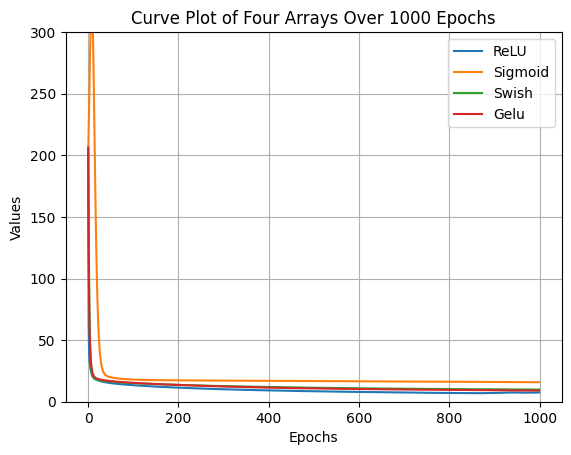

In [706]:
import matplotlib.pyplot as plt
import numpy as np

# Create data for the four lists
epochs = np.arange(0, 1000, 1)
# Create a figure and axis
fig, ax = plt.subplots()

# Plot the four arrays
ax.plot(epochs, loss_relu, label='ReLU')
ax.plot(epochs, loss_sig, label='Sigmoid')
ax.plot(epochs, loss_swish, label='Swish')
ax.plot(epochs, loss_gelu, label='Gelu')

# Set y-axis limits (adjust these based on your data)
ax.set_ylim(0, 300)

# Mark every multiple of 100 as a point
markers = np.arange(100, 1001, 100)

# Add labels, legend, and title
ax.set_xlabel('Epochs')
ax.set_ylabel('Values')
ax.legend(loc='upper right')
ax.set_title('Curve Plot of Four Arrays Over 1000 Epochs')

# Show the plot
plt.grid(True)
plt.show()
